# Лабораторная работа №4

ФИО:   
Группа: 

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре (Занятие №4 очное)

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/11600OkqdRzxc-xZmFTuBs099VeAqU_GlE0Bx6bBlIRE/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Пример импорта данных. Грузим данные

In [263]:
import pandas as pd
import numpy as np
import torch
import chardet
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Normalize, Lambda
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

In [264]:

path = '../LR2/spotify-2023.csv'
with open(path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

data = pd.read_csv(path, encoding=encoding)
data = data.drop(574)
data = data.dropna()

In [293]:
selected_features = [
    'artist_count',
    'released_year',
    'released_day',
    'released_month',
    # 'streams',
    'in_apple_playlists',
    'valence_%',
    'bpm',
    'energy_%'
]

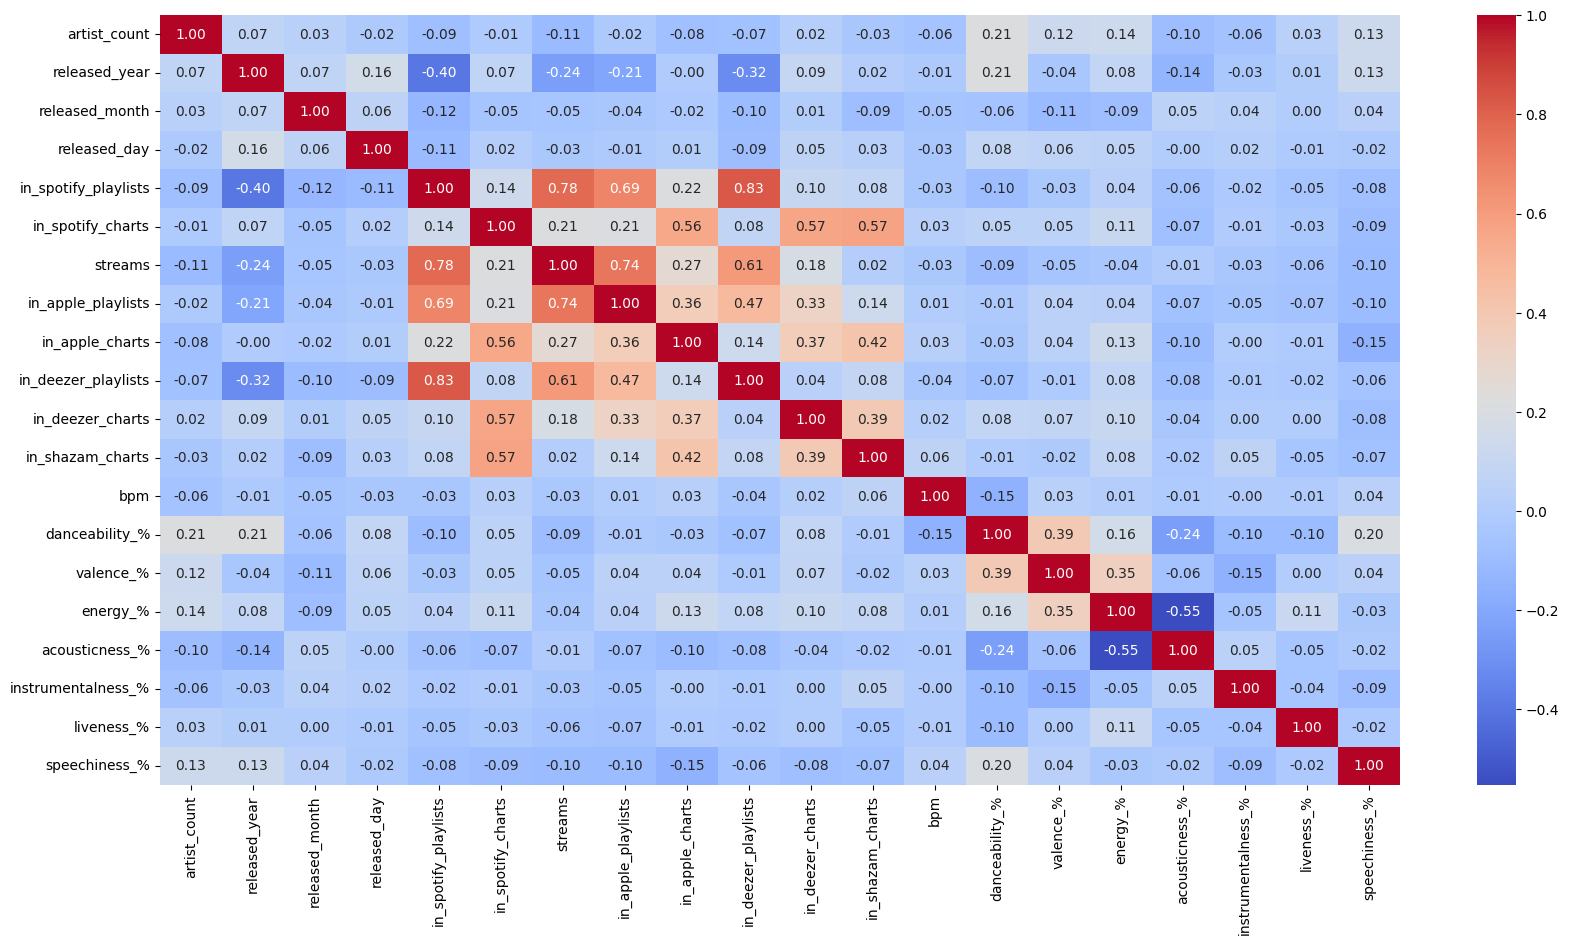

In [295]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feat = ['artist_count', 'released_year',
        'released_month', 'released_day', 'in_spotify_playlists',
        'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
        'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%',
        'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
selected_df = data[feat]
selected_df_copy = selected_df.copy()
for col in selected_df_copy.columns:
    selected_df_copy[col] = selected_df_copy[col].replace(
        ',', '', regex=True).astype(float)

corr_matrix = selected_df_copy.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Предобработка

In [ ]:

selected_features = [
    'artist_count',
    'released_year',
    'released_day',
    'released_month',
    # 'streams',
    # 'in_apple_playlists',
    'in_apple_charts',
    'valence_%',
    'bpm',
    # 'energy_%'
]
target_variable = 'danceability_%'
X = data[selected_features]
for feature in selected_features:
    X[feature] = X[feature].astype(float)
Y = data[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=20)

# Нормирование

In [772]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[selected_features])

X_test_scaled = scaler.transform(X_test[selected_features])

X.loc[X_train.index, selected_features] = X_train_scaled
X.loc[X_test.index, selected_features] = X_test_scaled

In [773]:
X.mean()

artist_count      -0.014390
released_year      0.019087
released_day      -0.032189
released_month     0.001711
in_apple_charts    0.016673
valence_%          0.012315
bpm               -0.001130
dtype: float64

# Создание датасетов и даталоудеров

In [774]:
import torch
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader


class SpotifyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


train_dataset = SpotifyDataset(X_train.values, y_train.values, )
test_dataset = SpotifyDataset(X_test.values, y_test.values,)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Цикл обучения

In [775]:
from sklearn.metrics import mean_absolute_error


def train_loop(dataloader, model, loss_fn, optimizer):
    lossess_array = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossess_array.append(loss.item())
        if batch % 3 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return lossess_array


def test_loop(dataloader, model, loss_fn):
    mae_array = []

    num_batches = len(dataloader)
    test_loss = 0
    mae = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            mae += mean_absolute_error(y.numpy(), pred.numpy())

    test_loss /= num_batches
    mae /= num_batches
    mae_array.append(mae)
    print(f"Test Error: \n Avg loss: {test_loss:>8f}, MAE: {mae:>8f} \n")
    return mae_array

In [776]:
def looping(epochs, model, loss_fn, optimizer):
    res_loss_array = []
    res_mae_array = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        res_loss_array.extend(train_loop(train_dataloader, model, loss_fn, optimizer))
        res_mae_array.extend(test_loop(test_dataloader, model, loss_fn))
    return res_loss_array, res_mae_array

# однослойная модель

In [777]:
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size,):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        out = self.fc1(x)
        return out

Epoch 1
-------------------------------
loss: 396483.437500  [    0/  652]
loss: 393899.625000  [  192/  652]
loss: 383731.968750  [  384/  652]
loss: 374201.625000  [  576/  652]
Test Error: 
 Avg loss: 362212.854167, MAE: 601.497253 

Epoch 2
-------------------------------
loss: 368661.312500  [    0/  652]
loss: 351773.093750  [  192/  652]
loss: 325901.156250  [  384/  652]
loss: 324345.687500  [  576/  652]
Test Error: 
 Avg loss: 310662.166667, MAE: 557.012695 

Epoch 3
-------------------------------
loss: 311936.906250  [    0/  652]
loss: 297924.375000  [  192/  652]
loss: 284760.406250  [  384/  652]
loss: 270702.812500  [  576/  652]
Test Error: 
 Avg loss: 258357.109375, MAE: 507.922099 

Epoch 4
-------------------------------
loss: 263105.093750  [    0/  652]
loss: 244855.015625  [  192/  652]
loss: 235079.125000  [  384/  652]
loss: 220592.109375  [  576/  652]
Test Error: 
 Avg loss: 213640.151042, MAE: 461.803640 

Epoch 5
-------------------------------
loss: 217973

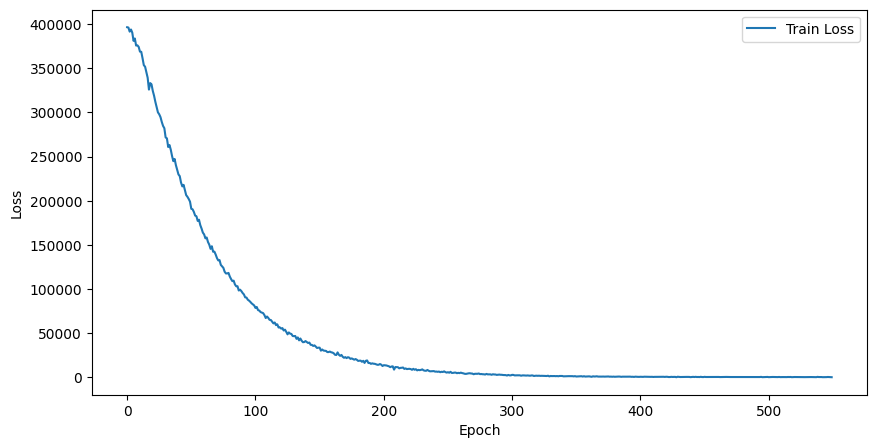

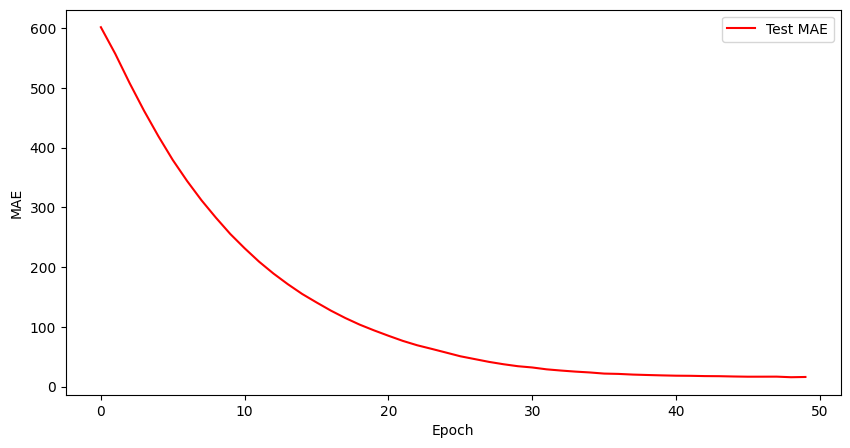

In [779]:
lossess_array = []
model1 = Model1(len(selected_features), 1) 
optimizer = optim.SGD(model1.parameters(), lr=1e-10,momentum=0.9)
loss_fn = nn.MSELoss()
epoches = 50
la, ma = looping(epoches, model1, loss_fn, optimizer)
plt.figure(figsize=(10, 5))
plt.plot(la, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ma, label='Test MAE', c='red')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# 1 скрытый слой

In [780]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Epoch 1
-------------------------------
loss: 4840.739746  [    0/  652]
loss: 3895.033936  [  192/  652]
loss: 2775.709473  [  384/  652]
loss: 2285.105713  [  576/  652]
Test Error: 
 Avg loss: 1651.745361, MAE: 37.810557 

Epoch 2
-------------------------------
loss: 1774.392212  [    0/  652]
loss: 1324.139648  [  192/  652]
loss: 696.562195  [  384/  652]
loss: 583.440063  [  576/  652]
Test Error: 
 Avg loss: 439.200104, MAE: 17.945036 

Epoch 3
-------------------------------
loss: 473.617554  [    0/  652]
loss: 340.757538  [  192/  652]
loss: 249.401199  [  384/  652]
loss: 232.631989  [  576/  652]
Test Error: 
 Avg loss: 221.709956, MAE: 12.312177 

Epoch 4
-------------------------------
loss: 235.824203  [    0/  652]
loss: 189.895325  [  192/  652]
loss: 183.472595  [  384/  652]
loss: 253.232422  [  576/  652]
Test Error: 
 Avg loss: 265.921346, MAE: 12.855688 

Epoch 5
-------------------------------
loss: 187.867722  [    0/  652]
loss: 242.461746  [  192/  652]
loss:

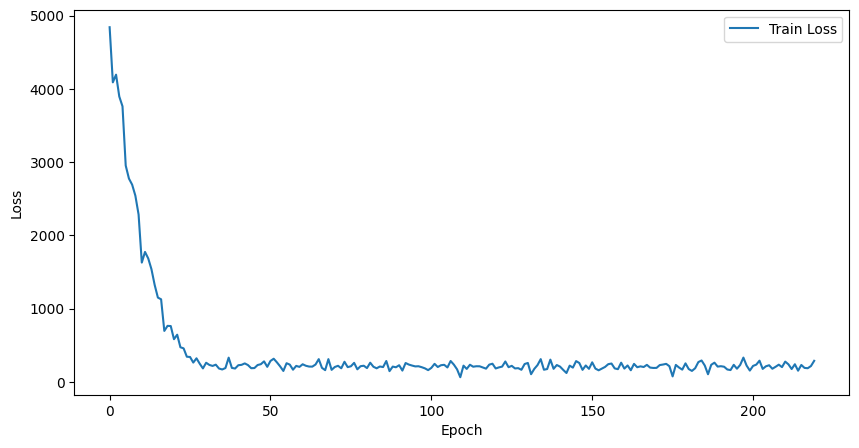

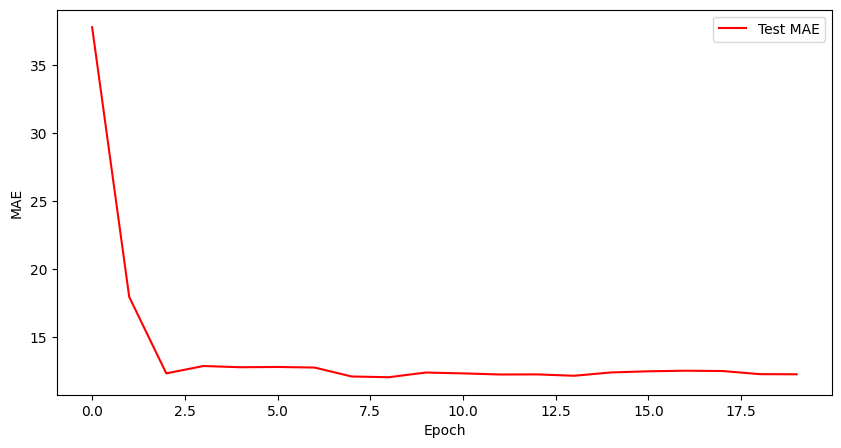

In [781]:
model2 = Model2(len(selected_features), 500, 1)  # 50 - размер скрытого слоя
optimizer = optim.Adam(model2.parameters(), lr=0.01)
loss_fn=nn.MSELoss()
lossess_array = []
epoches = 20
la, ma = looping(epoches, model2, loss_fn, optimizer)
plt.figure(figsize=(10, 5))
plt.plot(la, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ma, label='Test MAE', c='red')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# 4 скрытых слоя


In [782]:

class Model3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size*4)
        self.fc4 = nn.Linear(hidden_size*4, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

Epoch 1
-------------------------------
loss: 4820.414551  [    0/  652]
loss: 3865.769775  [  192/  652]
loss: 679.501404  [  384/  652]
loss: 872.871887  [  576/  652]
Test Error: 
 Avg loss: 217.914169, MAE: 12.160161 

Epoch 2
-------------------------------
loss: 222.065994  [    0/  652]
loss: 598.545593  [  192/  652]
loss: 225.978943  [  384/  652]
loss: 340.393829  [  576/  652]
Test Error: 
 Avg loss: 216.799555, MAE: 12.069115 

Epoch 3
-------------------------------
loss: 207.916702  [    0/  652]
loss: 320.196411  [  192/  652]
loss: 238.886780  [  384/  652]
loss: 263.246246  [  576/  652]
Test Error: 
 Avg loss: 264.008026, MAE: 12.928315 

Epoch 4
-------------------------------
loss: 208.594986  [    0/  652]
loss: 279.453857  [  192/  652]
loss: 233.122498  [  384/  652]
loss: 228.573853  [  576/  652]
Test Error: 
 Avg loss: 235.101873, MAE: 12.406448 

Epoch 5
-------------------------------
loss: 228.951553  [    0/  652]
loss: 215.005157  [  192/  652]
loss: 213.

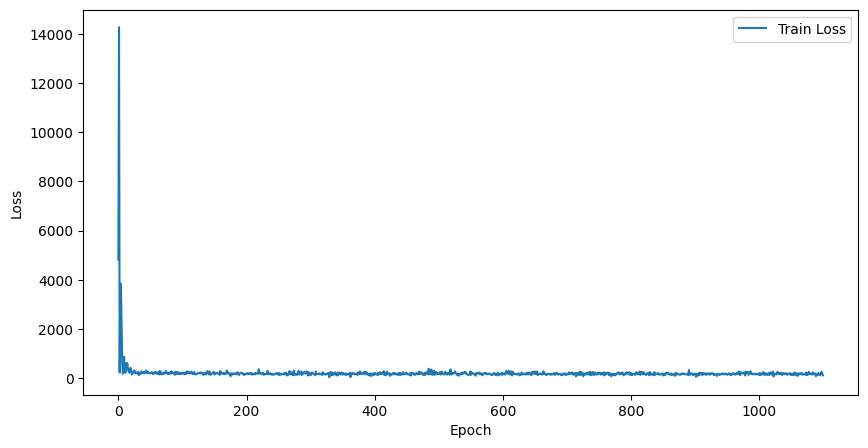

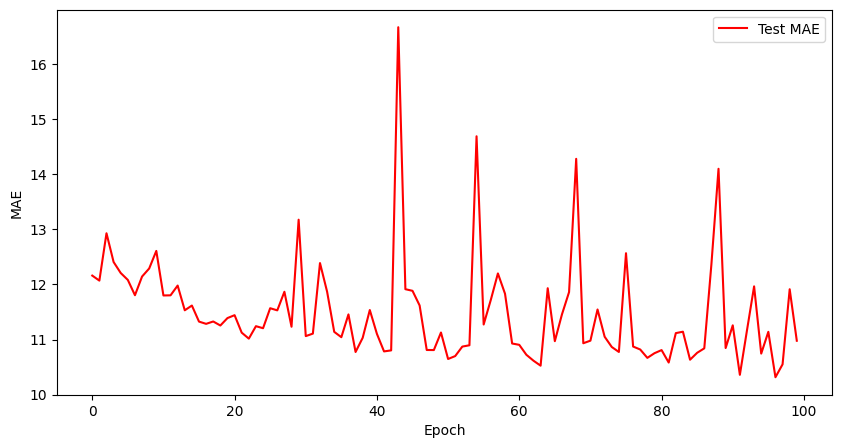

In [783]:
model3 = Model3(len(selected_features), 300, 1)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
epoches = 100
la, ma = looping(epoches, model3, loss_fn, optimizer)
plt.figure(figsize=(10, 5))
plt.plot(la, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ma, label='Test MAE', c='red')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [784]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error,  mean_squared_error


def GetMetrics(model):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test.values, dtype=torch.float32)).numpy()
        RMSE = np.sqrt(mean_squared_error(y_test.values, y_pred))
        MAE = mean_absolute_error(y_test.values, y_pred)
        MAPE = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100
        print(f"MAPE: {MAPE:.2f}%")
        print(f"MAE: {MAE:.2f}")
        print(f"RMSE: {RMSE:.2f}")

In [787]:
print(f"{'Модель 1':–^25}")
GetMetrics(model1)
print(f"{'Модель 2':–^25}")
GetMetrics(model2)
print(f"{'Модель 3':–^25}")
GetMetrics(model3)

––––––––Модель 1–––––––––
MAPE: 28.43%
MAE: 16.23
RMSE: 19.84
––––––––Модель 2–––––––––
MAPE: 22.64%
MAE: 12.37
RMSE: 15.03
––––––––Модель 3–––––––––
MAPE: 22.62%
MAE: 11.20
RMSE: 13.40
